In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from random import randint
import matplotlib.dates as mdates

# Data loading

In [2]:
medium_df = pd.read_csv("../dataset/partitions/medium_partition.csv", index_col=False)
medium_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date,33701.0,1.680706e+09,3.419155e+06,1.674810e+09,1.677525e+09,1.680842e+09,1.683754e+09,1.686292e+09
availability,33693.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
avg_alloc_mem,33693.0,1.119697e+05,2.338880e+04,0.000000e+00,9.507000e+04,1.104274e+05,1.247022e+05,2.400000e+05
avg_allocated_cpus_per_job,33694.0,7.974380e+02,2.402666e+02,-1.000000e+00,6.380731e+02,7.728302e+02,9.134590e+02,2.880000e+03
avg_allocated_nodes_per_job,33694.0,3.114549e+00,9.402489e-01,-1.000000e+00,2.492473e+00,3.018868e+00,3.568199e+00,1.125000e+01
node_total,31781.0,1.298227e+03,1.312735e+02,3.000000e+00,1.290000e+03,1.355000e+03,1.366000e+03,1.379000e+03
avg_cpus_load_lower,33693.0,6.847435e+01,1.485700e+02,0.000000e+00,3.446333e+01,4.888500e+01,6.488833e+01,1.664107e+03
nodes,31781.0,1.298227e+03,1.312735e+02,3.000000e+00,1.290000e+03,1.355000e+03,1.366000e+03,1.379000e+03
avg_cpus_load_upper,33693.0,1.578772e+02,2.221920e+02,2.000000e-02,9.289455e+01,1.078240e+02,1.275860e+02,3.910001e+03
avg_execution_time_per_job,33694.0,5.320246e+04,1.303897e+04,-1.000000e+00,4.455893e+04,5.213659e+04,6.115107e+04,1.862302e+05


In [3]:
def handle_missing_data(df, frequency="5min"):
    return df.resample(frequency).interpolate()

def plot_df_feature(df, feature_name, x_initial=0, x_final=None):
    if x_final is None:
        x_final = len(df)
    y = df[feature_name][x_initial:x_final]
    x = df.index[x_initial:x_final]
    fig, ax = plt.subplots()
    ax.set_xlabel("Time")
    ax.set_ylabel(feature_name)
    fig.set_size_inches(15, 5)
    ax.plot(x, y)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

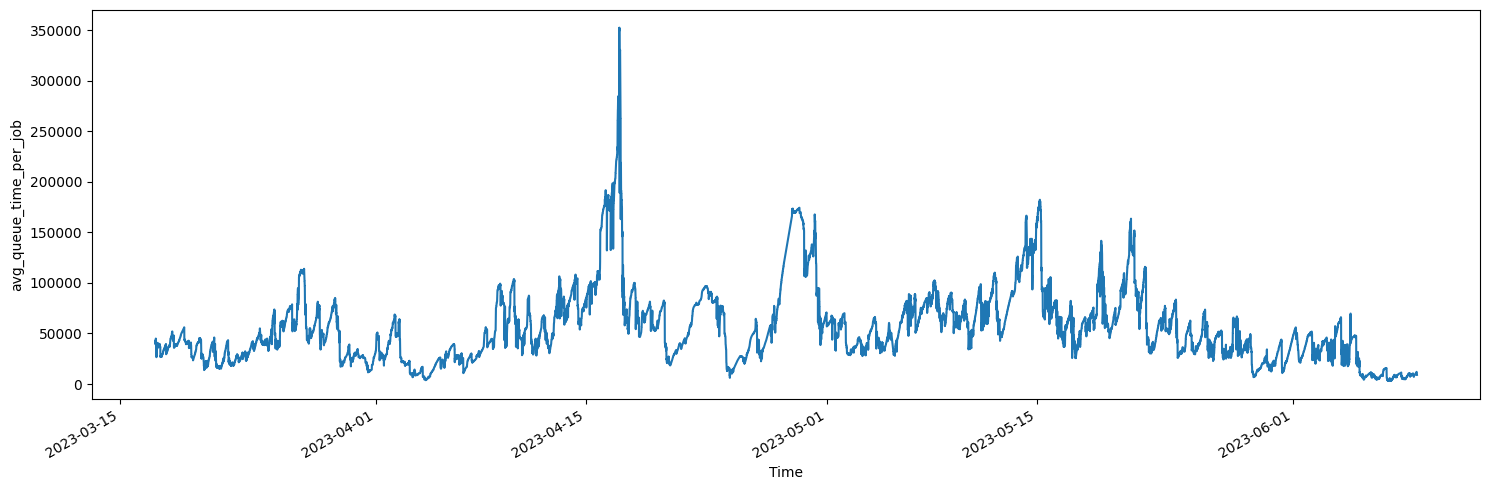

In [4]:

# Taking values in dataset after collection gap
medium_df_copy = medium_df.copy()

# 1- convert date to time index
medium_df_copy['date'] = pd.to_datetime(medium_df['date'].astype(np.int64), unit='s') 
medium_df_copy.set_index('date', inplace=True)
# 2- remove features with no variance
filter = medium_df_copy.std() == 0
features_to_drop = medium_df_copy.columns[filter]
medium_df_copy.drop(features_to_drop, axis=1, inplace=True)
# Sort time index
medium_df_copy.sort_index(inplace=True)
medium_df_copy.describe().transpose() 

# Filling gaps and resampling
avg_queue_time_series = medium_df_copy['avg_queue_time_per_job'][10900:]
dataset = avg_queue_time_series.to_frame()
dataset = handle_missing_data(dataset)

plot_df_feature(dataset, "avg_queue_time_per_job", x_initial=0, x_final=len(dataset))

# Data analysis

# Data processing

In [5]:
def prepare_time_series(data, target_col, past_observations_samples, future_sample=1, return_all_future_samples=False):
    X, y = [], []
    if isinstance(data, np.ndarray):
        aux = data[:,0]
        data = pd.DataFrame()
        data[target_col] = aux
    for i in range(data.shape[0]-past_observations_samples-future_sample+1):
        # print(i)
        x_index = i+past_observations_samples
        y_index = x_index+future_sample-1
        if future_sample > 1 and return_all_future_samples==False:
            seq_y = data[target_col].iloc[y_index]
        else:
            seq_y = data[target_col].iloc[x_index:y_index+1]
        seq_x = data[target_col].iloc[i:x_index]
        
        X.append(seq_x)
        y.append(seq_y)
    final_X = np.array(X).reshape(len(X), past_observations_samples, 1)
    final_y = np.array(y)
    return final_X, final_y

def resample_data(data, target_columns, datetime_column, resample_period):
    data['datetime_sample'] = pd.to_datetime(data[datetime_column], unit="s")
    resample_data = data.resample(resample_period, on='datetime_sample').power.mean()
    return resample_data

def scale_data(data, col):
    scaler = MinMaxScaler()
    norm_data = scaler.fit_transform(data[col].values.reshape(-1,1))
    return norm_data, scaler

def preprocessing_step(data, target_col, past_observations_samples, future_sample=1, 
                       do_scale_data=True, test_size=0.2,
                       return_tensors=True, return_all_future_samples=False):
    
    # 1- Normalize the data
    # 2- Create time series
         
    if do_scale_data==True:
        scaled_data, scaler = scale_data(data=data, col=target_col)
        data[target_col] = scaled_data
    
    train_size = int(len(scaled_data) * (1-test_size))
    train, test = data.iloc[0:train_size,:], data.iloc[train_size:len(scaled_data),:]
    test.reset_index(inplace=True, drop=True)
    
    x_train, y_train = prepare_time_series(train, target_col=target_col, 
                                           past_observations_samples=past_observations_samples, 
                                           future_sample=future_sample, 
                                           return_all_future_samples=return_all_future_samples)
    x_test, y_test = prepare_time_series(test, target_col=target_col, 
                                         past_observations_samples=past_observations_samples, 
                                         future_sample=future_sample, 
                                         return_all_future_samples=return_all_future_samples)
    
    if return_tensors == True:
        x_train = torch.Tensor(x_train)
        y_train = torch.Tensor(y_train)
        x_test = torch.Tensor(x_test)
        y_test = torch.Tensor(y_test)
       
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
        
    
    print('X Train subset shape: ',x_train.shape)
    print('Y Train subset shape: ', y_train.shape)
    print('X Test subset shape: ',x_test.shape)
    print('Y Test subset shape: ', y_test.shape)
    
    return {'scaled_data': data,
            'x_train':x_train,
            'y_train':y_train,
            'x_test':x_test,
            'y_test':y_test,
            'scaler':scaler}


class SequenceDataset(Dataset):
    def __init__(self, data, target_col, past_observations_samples, future_sample=1,
                 do_scale_data=True, test_size=0, return_tensors=True, 
                 return_all_future_samples=False, is_train=True):
        
        series_dict = preprocessing_step(data, target_col=target_col, 
                                         past_observations_samples=past_observations_samples,
                                         future_sample=future_sample,
                                         test_size=test_size,
                                         do_scale_data=do_scale_data, return_tensors=return_tensors,
                                         return_all_future_samples = return_all_future_samples)
        if is_train == True:
            self.X = series_dict['x_train']
            self.y = series_dict['y_train']
        else:
            self.X = series_dict['x_test']
            self.y = series_dict['y_test']
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        return self.X[i], self.y[i]

In [6]:
an_hour = int(60/5) # samples every 5 min
a_day = int(24 * an_hour)
past_observations_samples = a_day
future_sample = an_hour
return_tensors=True
return_all_future_samples = False
test_size = 0.2
do_scale_data = True

train_dataset = SequenceDataset(dataset, target_col="avg_queue_time_per_job", is_train=True,
                                past_observations_samples=past_observations_samples, 
                                future_sample=future_sample, test_size=test_size,
                                do_scale_data=do_scale_data, return_tensors=return_tensors,
                                return_all_future_samples = return_all_future_samples)

test_dataset = SequenceDataset(dataset, target_col="avg_queue_time_per_job", is_train=False,
                                past_observations_samples=past_observations_samples, 
                                future_sample=future_sample, test_size=test_size,
                                do_scale_data=do_scale_data, return_tensors=return_tensors,
                                return_all_future_samples = return_all_future_samples)

series_dict = preprocessing_step(dataset, target_col="avg_queue_time_per_job", 
                                 past_observations_samples=past_observations_samples, 
                                 future_sample=future_sample,
                                 test_size=test_size,
                                 do_scale_data=do_scale_data, return_tensors=return_tensors,
                                 return_all_future_samples = return_all_future_samples)

X Train subset shape:  torch.Size([19042, 288, 1])
Y Train subset shape:  torch.Size([19042])
X Test subset shape:  torch.Size([4537, 288, 1])
Y Test subset shape:  torch.Size([4537])
X Train subset shape:  torch.Size([19042, 288, 1])
Y Train subset shape:  torch.Size([19042])
X Test subset shape:  torch.Size([4537, 288, 1])
Y Test subset shape:  torch.Size([4537])
X Train subset shape:  torch.Size([19042, 288, 1])
Y Train subset shape:  torch.Size([19042])
X Test subset shape:  torch.Size([4537, 288, 1])
Y Test subset shape:  torch.Size([4537])


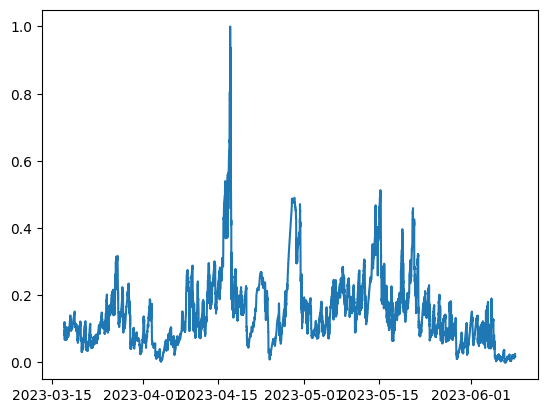

In [61]:
plt.plot(series_dict['scaled_data']['avg_queue_time_per_job'])

# Data forecasting

## Architecture Definition

In [7]:
def compute_loss(criterion, labels, model_outputs):
    if model_outputs.dim() == 1:
        model_outputs = model_outputs.reshape(-1,1)
    if labels.dim() == 1:
        labels = labels.reshape(-1,1)
    if labels.shape[1] == 1:
        return criterion(model_outputs, torch.Tensor(labels.reshape([-1,1])))
    return criterion(model_outputs, torch.Tensor(labels.squeeze()))

def compute_residulas(labels, model_outputs):
    if model_outputs.dim() == 1:
        model_outputs = model_outputs.reshape(-1,1)
    if labels.dim() == 1:
        labels = labels.reshape(-1,1)
    if labels.shape[1] == 1:
        res = model_outputs-torch.Tensor(labels.reshape([-1,1]))
        return res.detach().numpy()
    res = model_outputs-torch.Tensor(labels.squeeze())
    return res.detach().numpy()

def run_train(model, optimizer, train_dataloader, test_dataloader, num_epochs, num_train_batches, criterion):
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            if i % 10 == 0:
                print(f"Batch: {i+1} out of {num_train_batches}")
            outputs = model(inputs)
            optimizer.zero_grad()
            loss = compute_loss(criterion=criterion, labels=labels, model_outputs=outputs)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        if epoch % 2 == 0:
            val_loss, residuals = run_test(model=model, test_dataloader=test_dataloader, criterion=criterion)
            print("Epoch: %d. Training loss: %1.5f. Validation loss: %1.5f." % (epoch, epoch_loss/num_train_batches, val_loss))
    return epoch_loss/num_train_batches, val_loss, residuals
    
def run_test(model, test_dataloader, criterion):
    val_loss = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        #print(inputs.shape)
        outputs = model(inputs)
        loss = compute_loss(criterion=criterion, labels=labels, model_outputs=outputs)
        residuals = compute_residulas(labels=labels, model_outputs=outputs)
        val_loss += loss.item()
    return val_loss/len(test_dataloader), residuals

class forecasting_model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim:list=None, n_layers:list=None, dropout=0.2, 
                 output_size=1, bias=True, bidirectional=False, fc_outputs:list=None):
        super(forecasting_model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.n_layers = n_layers
        self.fc_outputs = fc_outputs
        
        self.initialize_values()
        
        self.gru_layer_1 = nn.GRU(input_size = input_dim,
                               hidden_size=self.hidden_dim[0],
                               num_layers=self.n_layers[0],
                               batch_first=True,
                               bias=bias,
                               bidirectional=bidirectional)
        self.dropout_layer_1 = nn.Dropout(dropout)
        self.gru_layer_2 = nn.GRU(input_size = self.hidden_dim[0],
                               hidden_size=self.hidden_dim[1],
                               num_layers=self.n_layers[1],
                               batch_first=True,
                               bias=bias,
                               bidirectional=bidirectional)
        self.dropout_layer_2 = nn.Dropout(dropout)
        self.fc_layer_1 = nn.Linear(self.hidden_dim[1], self.fc_outputs[0])
        self.dropout_layer_3 = nn.Dropout(dropout)
        self.fc_layer_2 = nn.Linear(self.fc_outputs[0], self.fc_outputs[1])
        self.dropout_layer_4 = nn.Dropout(dropout)
        self.output_layer = nn.Linear(self.fc_outputs[1], output_size)
    
    def initialize_values(self):
        if self.hidden_dim == None or len(self.hidden_dim) < 2:
            self.hidden_dim = [128, 64]
        if self.n_layers == None or len(self.n_layers) < 2:
            self.n_layers = [1, 1]
        if self.fc_outputs == None or len(self.fc_outputs) < 2:
            self.fc_outputs = [128, 64]
        
    
    def forward(self, x):
        
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        
        h0 = torch.zeros(self.n_layers[0], torch.Tensor(x).size(0), self.hidden_dim[0])
        h1 = torch.zeros(self.n_layers[1], torch.Tensor(x).size(0), self.hidden_dim[1])
        
        out, hidden_states = self.gru_layer_1(x, h0.detach())
        out = self.dropout_layer_1(out)
        out, hidden_states = self.gru_layer_2(out, h1.detach())
        out = self.dropout_layer_2(out)
        out = out[:, -1, :]
        out = self.fc_layer_1(out)
        out = self.dropout_layer_3(out)
        out = self.fc_layer_2(out)
        out = self.dropout_layer_4(out)
        out = self.output_layer(out)
        return out

In [8]:
num_epochs = 10
learning_rate = 0.01
hidden_size = [256,128]
num_layers = 2
dropout=0.05
batch_size = 128
input_size = 1
    
if return_all_future_samples == False:
    output_size = 1
else:
    output_size=future_sample

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_train_batches = len(train_dataloader)

model = forecasting_model(input_dim= input_size, 
                          output_size=output_size,
                          hidden_dim=hidden_size,
                          dropout=dropout)

print(f'Model architecture: \n{model}')

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print('Start training')
training_loss, validation_loss, residuals = run_train(
    model=model, optimizer=optimizer, train_dataloader=train_dataloader, test_dataloader=test_dataloader, 
    num_epochs=num_epochs, num_train_batches=num_train_batches, criterion=criterion)

Model architecture: 
forecasting_model(
  (gru_layer_1): GRU(1, 256, batch_first=True)
  (dropout_layer_1): Dropout(p=0.05, inplace=False)
  (gru_layer_2): GRU(256, 128, batch_first=True)
  (dropout_layer_2): Dropout(p=0.05, inplace=False)
  (fc_layer_1): Linear(in_features=128, out_features=128, bias=True)
  (dropout_layer_3): Dropout(p=0.05, inplace=False)
  (fc_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer_4): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)
Start training
Batch: 1 out of 149
Batch: 11 out of 149
Batch: 21 out of 149
Batch: 31 out of 149
Batch: 41 out of 149
Batch: 51 out of 149
Batch: 61 out of 149
Batch: 71 out of 149
Batch: 81 out of 149
Batch: 91 out of 149
Batch: 101 out of 149
Batch: 111 out of 149
Batch: 121 out of 149
Batch: 131 out of 149
Batch: 141 out of 149
Epoch: 0. Training loss: 0.05260. Validation loss: 0.01124.
Batch: 1 out of 149
Batch: 11 out of 149
Batch: 21 out 

In [9]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Save train model
torch.save(model.state_dict(), "model.pth")

# Save residuals
import pickle
with open('residuals.obj', 'wb') as residuals_file:
    pickle.dump(residuals, residuals_file)



Model's state_dict:
gru_layer_1.weight_ih_l0 	 torch.Size([768, 1])
gru_layer_1.weight_hh_l0 	 torch.Size([768, 256])
gru_layer_1.bias_ih_l0 	 torch.Size([768])
gru_layer_1.bias_hh_l0 	 torch.Size([768])
gru_layer_2.weight_ih_l0 	 torch.Size([384, 256])
gru_layer_2.weight_hh_l0 	 torch.Size([384, 128])
gru_layer_2.bias_ih_l0 	 torch.Size([384])
gru_layer_2.bias_hh_l0 	 torch.Size([384])
fc_layer_1.weight 	 torch.Size([128, 128])
fc_layer_1.bias 	 torch.Size([128])
fc_layer_2.weight 	 torch.Size([64, 128])
fc_layer_2.bias 	 torch.Size([64])
output_layer.weight 	 torch.Size([1, 64])
output_layer.bias 	 torch.Size([1])


In [8]:
#Load model
hidden_size = [256,128]
input_size = 1
dropout=0.05
if return_all_future_samples == False:
    output_size = 1
else:
    output_size=future_sample
model = forecasting_model(input_dim= input_size, 
                          output_size=output_size,
                          hidden_dim=hidden_size,
                          dropout=dropout)

forecasting_model(input_dim= input_size, 
                          output_size=output_size,
                          hidden_dim=hidden_size,
                          dropout=dropout)
model.load_state_dict(torch.load("model.pth"))
model.eval()

# Load residuals
residuals = None
with open('residuals.obj', 'rb') as residuals_file:
   residuals = pickle.load(residuals_file)

residuals

forecasting_model(
  (gru_layer_1): GRU(1, 256, batch_first=True)
  (dropout_layer_1): Dropout(p=0.05, inplace=False)
  (gru_layer_2): GRU(256, 128, batch_first=True)
  (dropout_layer_2): Dropout(p=0.05, inplace=False)
  (fc_layer_1): Linear(in_features=128, out_features=128, bias=True)
  (dropout_layer_3): Dropout(p=0.05, inplace=False)
  (fc_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer_4): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

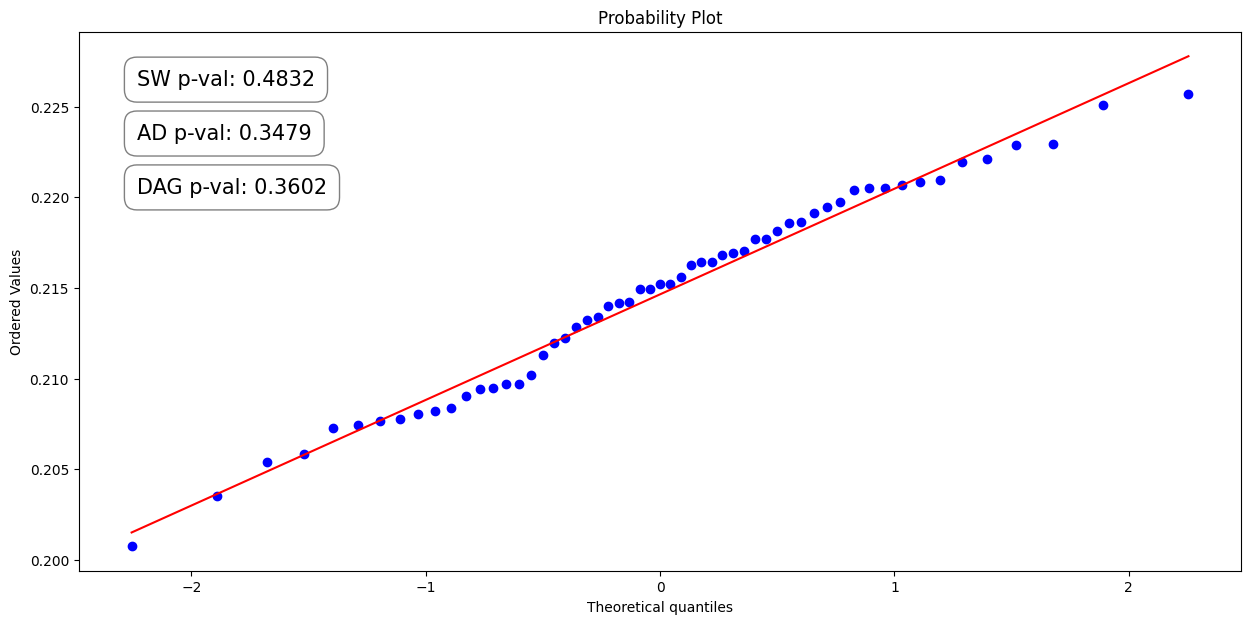

In [65]:
# Checking the normal distribution of residuals
# Required to compute the confidence intervale. 
# Test are showing residuals are not normally distributed so the condidence interval cannot be determined.
# Fixme during the trainig process, only the last epoch residuals are returned and not the complete set
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad

sw_result = stats.shapiro(residuals)
ad_result = normal_ad(residuals, axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(residuals.reshape(-1,), plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate(f"AD p-val: {ad_result[1][0]:.4f}", xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate(f"DAG p-val: {dag_result[1][0]:.4f}", xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

In [12]:
def get_z_score(CI_level=0.95):
    if CI_level == 0.90:
        return 1.645
    if CI_level == 0.95:
        return 1.96
    if CI_level == 0.99:
        return 2.579
    return 1.96

def get_rmse(residuals):
    return np.sqrt(sum([x**2 for x in residuals]) / len(residuals))

def plot_with_ci(actual_data, predictions, col_label, test_size, residuals, scaler, ci=0.95):
    if predictions.shape[1] > 1:
        predictions = predictions[:,-1].reshape(-1, 1)
    actual_data = actual_data.reshape(-1,1)
    predictions = scaler.inverse_transform(predictions.detach().numpy())
    actual_data = scaler.inverse_transform(actual_data.reshape(-1,1))
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(np.arange(0,len(predictions)), actual_data, color='#fc7d0b', label='Actual')
    ax.scatter(np.arange(0,len(predictions)),predictions)
    if ci is not None:
        max_margin = scaler.inverse_transform(max_margin.reshape(-1,1))
        band_size = get_rmse(residuals)*get_z_score(ci)
        min_margin = actual_data-band_size
        max_margin = actual_data+band_size
        min_margin = scaler.inverse_transform(min_margin.reshape(-1,1))
        ax.fill_between(np.arange(0,len(predictions)), min_margin.reshape(-1,), max_margin.reshape(-1,), color='b', alpha=.1)
        title = "Forecasting with "+str(ci*100) + '% Confidence'
    else:
        title = "Forecasting"
    ax.axvline(x=len(predictions)-test_size, linestyle='--', color="black")
    ax.annotate("Validation subset", xy=(0.85,0.95),xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
    ax.legend(['Actual Data', 'Predictions', 'Confidence Interval'], loc='lower left')
    ax.set_title(title)
    ax.set_xlabel('Samples')
    ax.set_ylabel(col_label)
    plt.show()

In [10]:
series_dict['scaled_data']

,avg_queue_time_per_job
date,
2023-03-17 07:55:00,0.111457
2023-03-17 08:00:00,0.111457
2023-03-17 08:05:00,0.109892
2023-03-17 08:10:00,0.109892
2023-03-17 08:15:00,0.109350
...,...
2023-06-09 06:15:00,0.016709
2023-06-09 06:20:00,0.016763
2023-06-09 06:25:00,0.016763


In [10]:
print(model)

forecasting_model(
  (gru_layer_1): GRU(1, 256, batch_first=True)
  (dropout_layer_1): Dropout(p=0.05, inplace=False)
  (gru_layer_2): GRU(256, 128, batch_first=True)
  (dropout_layer_2): Dropout(p=0.05, inplace=False)
  (fc_layer_1): Linear(in_features=128, out_features=128, bias=True)
  (dropout_layer_3): Dropout(p=0.05, inplace=False)
  (fc_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer_4): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [9]:
a_week = a_day * 7
real_data = series_dict['scaled_data']['avg_queue_time_per_job'].values[-a_week:].reshape(-1, 1)
X, y = prepare_time_series(real_data, 
                           target_col='avg_queue_time_per_job',
                           past_observations_samples=past_observations_samples,
                           future_sample=future_sample)

time_axis = series_dict['scaled_data'][-a_week:].index


In [10]:
predictions = model(X)

In [ ]:
# predictions = []
# index = 0
# for input_features in X:
#   index += 1
#   print (index)
#   predictions.append(model(input_features.reshape(1, -1, 1))[0])
# predictions

In [13]:
plot_with_ci(y, predictions, series_dict['y_test'].shape[0], time_axis, residuals, series_dict['scaler'], ci=0.90)

NameError: name 'residuals' is not defined